PDHG algorithm

In [1]:
# Package import
from mri.operators import NonCartesianFFT, WaveletUD2, WaveletN , gradient
from mri.operators.utils import convert_mask_to_locations, convert_locations_to_mask, \
                    gridded_inverse_fourier_transform_nd
from mri.reconstructors import SingleChannelReconstructor
import pysap
from pysap.data import get_sample_data
import time


                 .|'''|       /.\      '||'''|,
                 ||          // \\      ||   ||
'||''|, '||  ||` `|'''|,    //...\\     ||...|'
 ||  ||  `|..||   .   ||   //     \\    ||
 ||..|'      ||   |...|' .//       \\. .||
 ||       ,  |'
.||        ''

Package version: 0.0.3

License: CeCILL-B

Authors: 

Antoine Grigis <antoine.grigis@cea.fr>
Samuel Farrens <samuel.farrens@cea.fr>
Jean-Luc Starck <jl.stark@cea.fr>
Philippe Ciuciu <philippe.ciuciu@cea.fr>

Dependencies: 

scipy          : >=1.3.0   - required | 1.3.0     installed
numpy          : >=1.16.4  - required | 1.16.4    installed
matplotlib     : >=3.0.0   - required | 3.1.1     installed
astropy        : >=3.0.0   - required | 3.2.1     installed
nibabel        : >=2.3.2   - required | 2.5.1     installed
pyqtgraph      : >=0.10.0  - required | 0.10.0    installed
progressbar2   : >=3.34.3  - required | ?         installed
modopt         : >=1.4.0   - required | 1.4.1     installed
scikit-learn   : >=0.19.1  - requi

In [2]:
from modopt.math.metrics import ssim

import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

## Import data and add noise

### Radial Fourier operator

In [3]:
#Oasis image
all_images = [ "oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii"]
              #,"../oasis_data/sub-OAS30278_ses-d1325_run-02_T1w.nii" ]
im = nib.load("oasis_data/sub-OAS30001_ses-d0129_run-01_T1w.nii")
im = im.get_fdata()

u0_mat = (1+0j)*im[ :, 30:206, 124 ]
n=len(u0_mat)

In [4]:
n_rad = int( n / 2 )
n_ang = int( n * np.pi )


phi = np.linspace( 0, 2 * np.pi, n_ang, endpoint = False )
rad = np.linspace( 0.5 / n_rad, 0.5, (n_rad-1), endpoint = False )
Phi, Rad = np.meshgrid( phi, rad )

X = ( Rad * np.cos( Phi ) ).flatten( 'C' )
Y = ( Rad * np.sin( Phi ) ).flatten( 'C' )

full_kspace_loc = np.stack( ( X, Y ), axis = 1 )  
full_kspace_loc = np.vstack( ( np.array( [ 0, 0 ] ), full_kspace_loc ) )

m = convert_locations_to_mask(full_kspace_loc,u0_mat.shape)
fourier_op = NonCartesianFFT(samples=full_kspace_loc, shape=u0_mat.shape,implementation='cpu')
y = (1+0j)*fourier_op.op(u0_mat)+0.15*np.mean(u0_mat)*np.random.randn(2*n_ang*(n_rad-1)+2).view(np.complex128)

#p = np.ones(len(y))
p = np.ones(len(y)+1)

/home/guillaume/temp/pysap-mri/mri/operators/fourier/utils.py:78: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [5]:
pysap.Image(data=m).show()

### Operators

In [6]:
#Wavelet
linear_op = WaveletN(wavelet_name="sym8",nb_scale=3,padding_mode = "periodization")
#linear_op = WaveletUD2(wavelet_id=24,nb_scale=3)

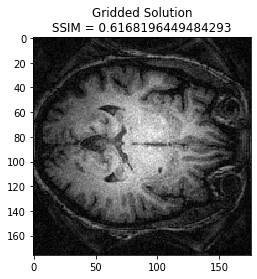

In [7]:
grid_space = np.linspace(-0.5, 0.5, num=u0_mat.shape[0])
grid2D = np.meshgrid(grid_space, grid_space)
grid_soln = gridded_inverse_fourier_transform_nd(fourier_op.samples, p[:-1]*y,
                                                 tuple(grid2D), 'linear')
plt.imshow(np.abs(grid_soln), cmap='gray')
# Calculate SSIM
base_ssim = ssim(grid_soln, u0_mat)
plt.title('Gridded Solution\nSSIM = ' + str(base_ssim))
plt.show()

## Reconstruction

In [8]:
# Specific files import
from LowerLevel.prox import prox_G,prox_F1_dual,prox_F2_dual
from LowerLevel.pdhg import pdhg
from LowerLevel.cost_utils import f1,f2,g

In [9]:
param = {"epsilon":1e-3,"gamma":1e-10}
p[-1] = 25

In [10]:
print(g(fourier_op.adj_op(y),param["epsilon"]),
      f2(linear_op.op(fourier_op.adj_op(y)),p[-1],param["gamma"]),
      f1(fourier_op.adj_op(y),p[:-1],y,fourier_op))
print(g(u0_mat,param["epsilon"]),
      f2(linear_op.op(u0_mat),p[-1],param["gamma"]),
      f1(u0_mat,p[:-1],y,fourier_op))

555665162.0072938 546614331.7311928 31776266995998.273
493727.504 30491721.465768337 20638554.265258964


In [11]:
# -- Solving --
uk,norms,energy,ssims = pdhg(y , p ,
                             fourier_op = fourier_op,
                             linear_op = linear_op,
                             param = param,
                             const = {"sigma":0.5,"tau":1},
                             ground_truth=u0_mat,
                             maxit=50,
                             compute_energy = True,
                             mask_type="radial")

Sigma: 0.5 
Tau: 1


/home/guillaume/pysap-mri/Learning Sampling Pattern/LowerLevel/prox.py:19: RuntimeWarning: invalid value encountered in sqrt
  x/np.abs(x)*(gamma+gamma**2/2/c-gamma/c*np.sqrt((c+0.5*gamma)**2-c*np.abs(x))))


10  iterations:
Cost: 106258669165.50903 
Norm: 1.882795083140202 

20  iterations:
Cost: 78173396.51985008 
Norm: 0.216100100978768 

30  iterations:
Cost: 42701194.27926142 
Norm: 0.012724342547159078 

40  iterations:
Cost: 42625678.08300359 
Norm: 0.004076960811178076 

50  iterations:
Cost: 42617433.52538849 
Norm: 0.0016070421448940676 

Finished in 177.73194766044617 seconds.


In [12]:
#Showing
print(ssim(u0_mat,uk))
pysap.Image(data = np.abs(uk)).show()

0.9152707612627816


In [13]:
print(g(uk,param["epsilon"]),
      f2(linear_op.op(uk),p[-1],param["gamma"]),
      f1(uk,p[:-1],y,fourier_op))

469653.0349520217 25304085.25782525 16843695.232611217


In [14]:
pysap.Image(data = np.abs(uk-u0_mat)).show()

In [15]:
pysap.Image(data = np.arctan(np.imag(uk)/np.real(uk))).show()

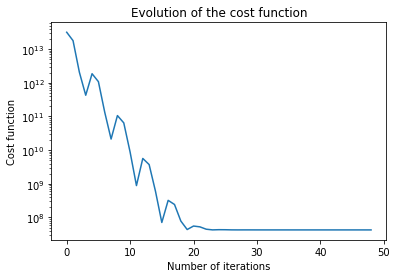

In [16]:
plt.plot(energy[1:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Cost function")
plt.title("Evolution of the cost function")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/radial/energy.png")
plt.show()

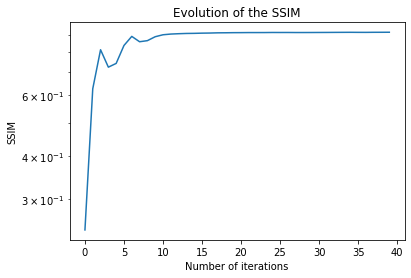

In [17]:
plt.plot(ssims[10:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("SSIM")
plt.title("Evolution of the SSIM")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/radial/metrics.png")
plt.show()

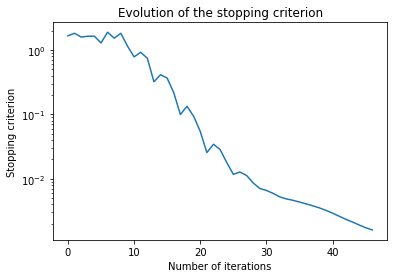

In [18]:
plt.plot(norms[3:])
plt.yscale("log")
plt.xlabel("Number of iterations")
plt.ylabel("Stopping criterion")
plt.title("Evolution of the stopping criterion")
plt.yscale("log")
#plt.savefig("Results/radial V cartesian/radial/norms.png")
plt.show()